# Extended Data Figure 5: Hypothesis testing with CEBRA.

### Example data from a hippocampus recording session (Rat 1).

- We test possible relationships between three experimental variables (rat location, velocity, movement direction) and the neural recordings (120 neurons, not shown).

In [15]:
import glob
import sys
import numpy as np
import itertools
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import torch
import json


def load_emission(path, which):
    emission = torch.load(path)
    return emission[which]


def load_loss(path):
    emission = torch.load(path, map_location="cpu")
    return emission['loss']


def load_args(path):
    with open(path, "r") as fh:
        idx = [5, 7, 9, -1]
        args = json.load(fh)
        position, velocity, direction, loader = [
            args['data'].split("-")[i] for i in idx
        ]
        args['direction'] = direction
        args['velocity'] = velocity
        args['position'] = position
        args['loader'] = loader
        return args, (position, velocity, direction, loader, args['num_output'])


def prepare_data():
    keys = ['position', 'velocity', 'direction']
    options = list(itertools.product(keys, ['original', 'shuffle']))
    options = np.array(options).reshape(3, 2,
                                        2).transpose(1, 0,
                                                     2).reshape(6, 2).tolist()
    options = list(map(tuple, options))
    print(options)

    import pandas as pd

    def rep(k):
        if len(k) == 0:
            return "none"
        if len(k) == 2:
            return "none"
        return k.pop()

    args = []
    for selection in itertools.product(options, options):
        kwargs = {opt: set() for opt in keys}
        for k, v in selection:
            kwargs[k].add(v)
        args.append({
            "src": tuple(selection[0]),
            "tgt": tuple(selection[1]),
            "config": tuple(rep(kwargs[k]) for k in keys)
        })

    df = pd.DataFrame(args).pivot("src", "tgt")
    return df


def scatter(data, ax):

    pca = PCA(2, whiten=False)
    pca.fit(data)
    data = pca.transform(data)[:, :]
    data /= data.max(keepdims=True)
    x, y = data[:, :2].T

    ax.scatter(x, y, s=1, alpha=.25, edgecolor='none', c='k')  #, c = f"C{n}")


def apply_style(ax):
    sns.despine(ax=ax, trim=True, left=True, bottom=True)
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis=u'both', which=u'both', length=0)
    ax.set_aspect('equal')


def scatter_grid(df, dim):
    fig, axes = plt.subplots(6, 6, figsize=(5, 5), dpi=200)

    df = df.iloc[[0, 2, 4, 1, 3, 5], [0, 2, 4, 1, 3, 5]]

    for i, (index, row) in enumerate(zip(df.index, axes)):
        for j, (column, ax) in enumerate(zip(df.columns, row)):
            apply_style(ax)
            if i == 5:
                ax.set_xlabel('{}\n{}'.format(*column[1]), fontsize=6)
            if j == 0:
                ax.set_ylabel('{}\n{}'.format(*index), fontsize=6)
            if j > i:
                continue
            entry = df[column][index]
            key = entry + ("continuous", dim, "train")
            if entry == ("none", "none", "none"):
                continue
            emission = files[key]

            scatter(emission[:, :], ax=ax)


def plot_heatmap(df, dim):

    def to_heatmap(entry):
        key = entry + ("continuous", dim, "loss")
        return min(files.get(key, [float("nan")]))

    df = df.iloc[[0, 2, 4, 1, 3, 5], [0, 2, 4, 1, 3, 5]]
    labels = ['{}\n{}'.format(*i) for i in df.index]
    hm = df.applymap(to_heatmap)
    for i, j in itertools.product(range(len(hm)), range(len(hm))):
        if j > i:
            hm.iloc[i, j] = float("nan")

    plt.figure(figsize=(4, 4), dpi=150)
    sns.heatmap(hm,
                cmap='gray',
                xticklabels=labels,
                yticklabels=labels,
                annot=True,
                fmt=".2f",
                square=True)
    plt.xlabel("")
    plt.ylabel("")
    plt.gca().set_xticklabels(labels, fontsize=8)
    plt.gca().set_yticklabels(labels, fontsize=8)
    plt.show()


df = prepare_data()

emission_files = sorted(glob.glob("../data/EDFigure5/*/emission*"))
arg_files = sorted(glob.glob("../data/EDFigure5/*/args.json"))

losses = [load_emission(e, 'losses') for e in emission_files]
emissions = [load_emission(e, 'train') for e in emission_files]
emissions_test = [load_emission(e, 'test') for e in emission_files]
args = [load_args(path) for path in arg_files]
files = {
    keys + ('train',): values for (_, keys), values in zip(args, emissions)
}
files.update({
    keys + ('test',): values for (_, keys), values in zip(args, emissions_test)
})
files.update(
    {keys + ('loss',): values for (_, keys), values in zip(args, losses)})

[('position', 'original'), ('velocity', 'original'), ('direction', 'original'), ('position', 'shuffle'), ('velocity', 'shuffle'), ('direction', 'shuffle')]


### Relationship between velocity and position.

In [16]:
import os
import joblib


def prepare_dataset(cache='../data/EDFigure5/achilles_behavior.jl'):
    """If you have CEBRA installed, you can adapt this function to load other
  rats, or adapt the data loading in other ways. Otherwise, pre-computed data
  will be loaded."""
    if not os.path.exists(cache):
        import cebra.datasets
        DATADIR = '/home/stes/projects/neural_cl/cebra_public/data'
        dataset = cebra.datasets.init(
            "rat-hippocampus-achilles-3fold-trial-split-0", root=DATADIR)
        index = dataset.index
        joblib.dump(index, cache)
    return joblib.load(cache)

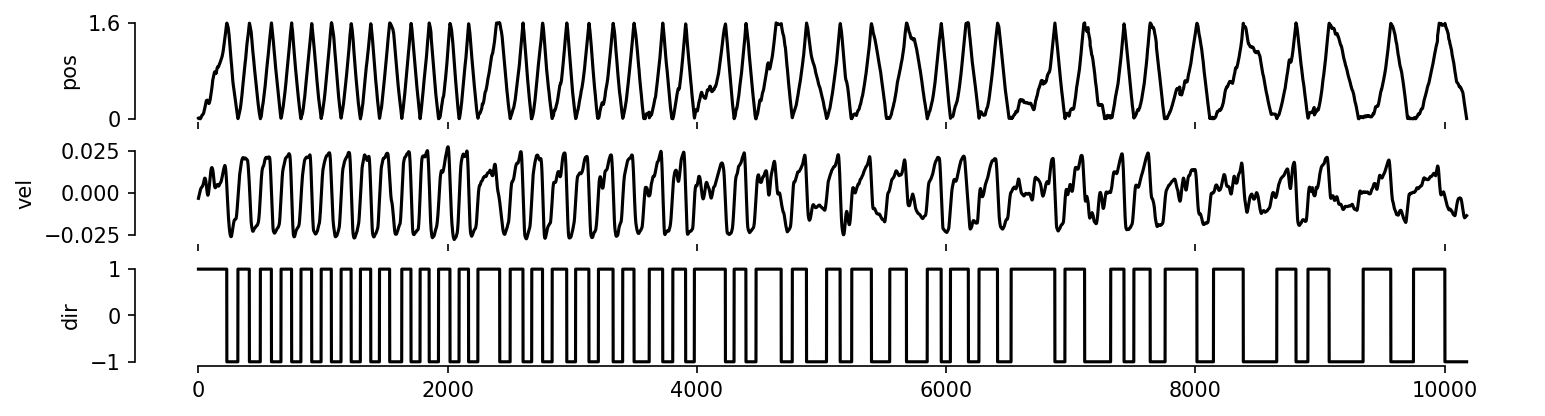

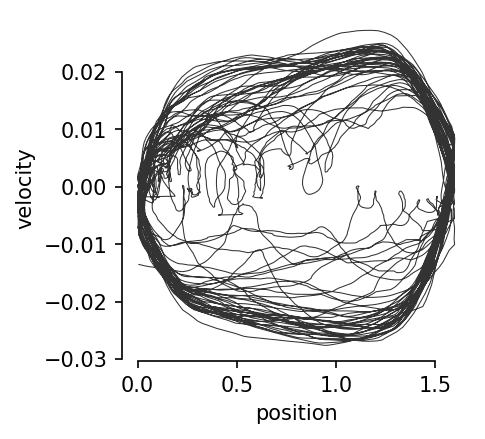

In [17]:
import scipy.signal
import matplotlib.pyplot as plt
import seaborn as sns


def dataset_plots(index):
    """Make a summary plot of the hippocampus dataset.
  
  Args:
    index is the [position, left, right] behavior index also used for training
    CEBRA models.
  """

    # preprocess the dataset
    position = index[:, 0]
    velocity = scipy.signal.savgol_filter(index[:, 0],
                                          window_length=31,
                                          polyorder=2,
                                          deriv=1)
    accel = scipy.signal.savgol_filter(index[:, 0],
                                       window_length=11,
                                       polyorder=2,
                                       deriv=2)
    direction = index[:, 1] - index[:, 2]

    # plot figure
    fig, axes = plt.subplots(3, 1, figsize=(12, 3), sharex=True, dpi=150)
    axes[0].plot(index[:, 0], c='k')
    axes[0].set_ylim([-0.05, 1.65])
    axes[0].set_yticks([0, 1.6])
    axes[0].set_yticklabels([0, 1.6])

    axes[1].plot(velocity, c='k')
    axes[2].plot(direction, c='k')

    for i, ax in enumerate(axes):
        sns.despine(ax=ax, trim=True, bottom=i != 2)
    for ax, lbl in zip(axes, ['pos', 'vel', 'dir']):
        ax.set_ylabel(lbl)

    plt.show()

    plt.figure(figsize=(3, 3), dpi=150)
    plt.plot(index[:, 0], velocity, linewidth=.5, color='black', alpha=.8)
    plt.xlabel("position")
    plt.ylabel("velocity")
    sns.despine(trim=True)
    plt.show()


index = prepare_dataset()
dataset_plots(index)

### Training CEBRA with three-dimensional outputs on every single experimental variable (main diagonal) and every combination of two variables.

- All variables are treated as "continuous" in this experiment. We compare original to shuffled variables (shuffling is done by permuting all samples over the time dimension) as a control. We project the original three dimensional space onto the first principal components. We show the minimum value of the InfoNCE loss on the trained embedding for all combinations in the confusion matrix (lower number is better). Either velocity or direction, paired with position information is needed for maximum structure in the embedding (highlighted, colored), yielding lowest InfoNCE error.

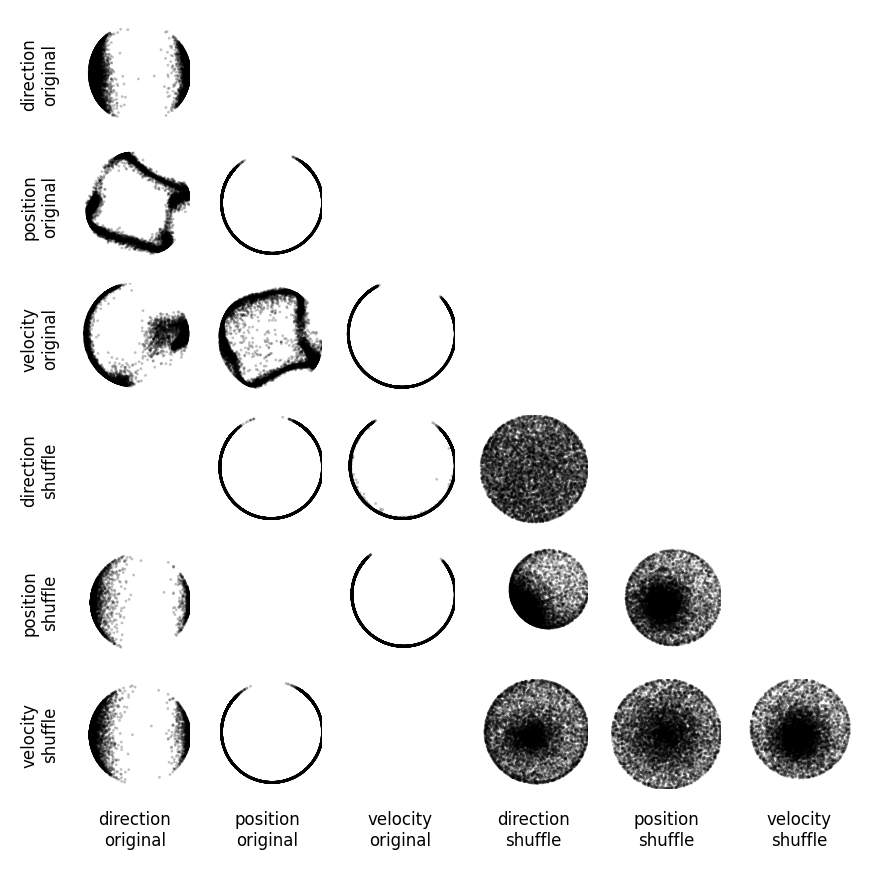

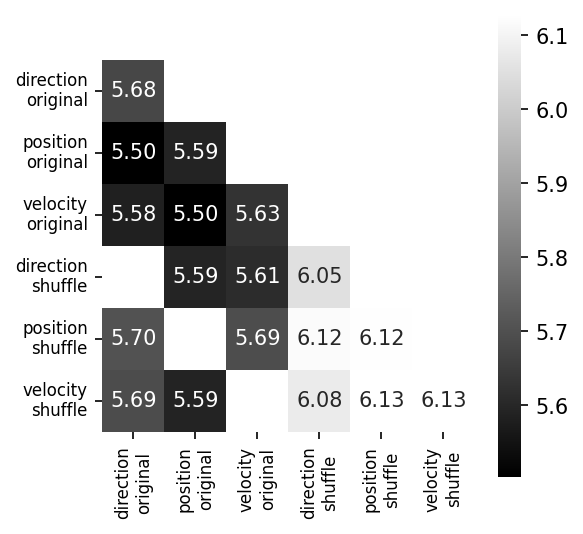

In [18]:
scatter_grid(df, 3)
plot_heatmap(df, 3)

### Using an eight-dimensional CEBRA embedding does not qualitatively alter the results.

- We again report the first two principal components as well as InfoNCE training error upon convergence, and find non-trivial embeddings with lowest training error for combinations of direction/velocity and position.

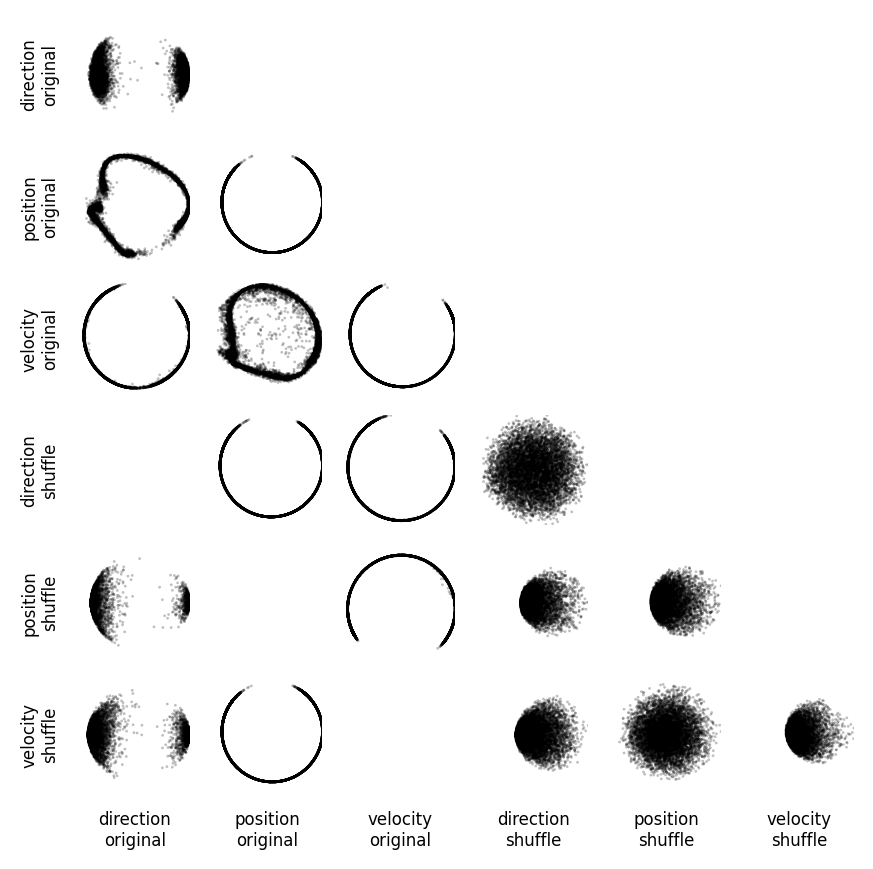

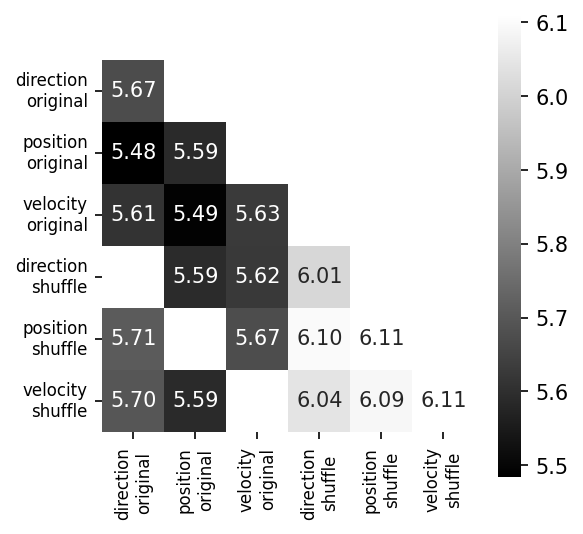

In [19]:
scatter_grid(df, 8)
plot_heatmap(df, 8)

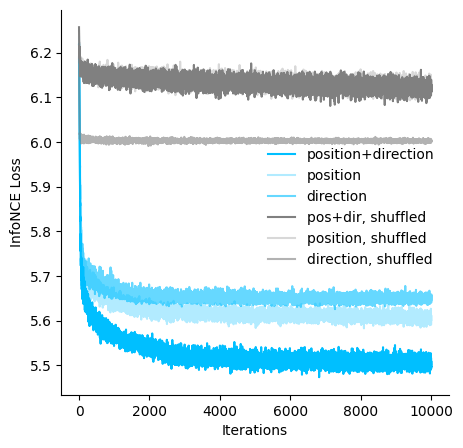

In [27]:
hypothesis_loss=joblib.load('../data/EDFigure5/hypothesis_testing_loss.jl')

fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)
ax.plot(hypothesis_loss['posdir'], c='deepskyblue', label = 'position+direction')
ax.plot(hypothesis_loss['pos'], c='deepskyblue', alpha = 0.3, label = 'position')
ax.plot(hypothesis_loss['dir'], c='deepskyblue', alpha=0.6,label = 'direction')
ax.plot(hypothesis_loss['posdir-shuffled'], c='gray', label = 'pos+dir, shuffled')
ax.plot(hypothesis_loss['pos-shuffled'], c='gray', alpha = 0.3, label = 'position, shuffled')
ax.plot(hypothesis_loss['dir-shuffled'],c='gray', alpha=0.6,label = 'direction, shuffled')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Iterations')
ax.set_ylabel('InfoNCE Loss')
plt.legend(bbox_to_anchor=(0.5,0.3), frameon = False )
plt.show()

In [24]:
hypothesis_decode=joblib.load('../data/EDFigure5/hypothesis_testing_decode.jl')

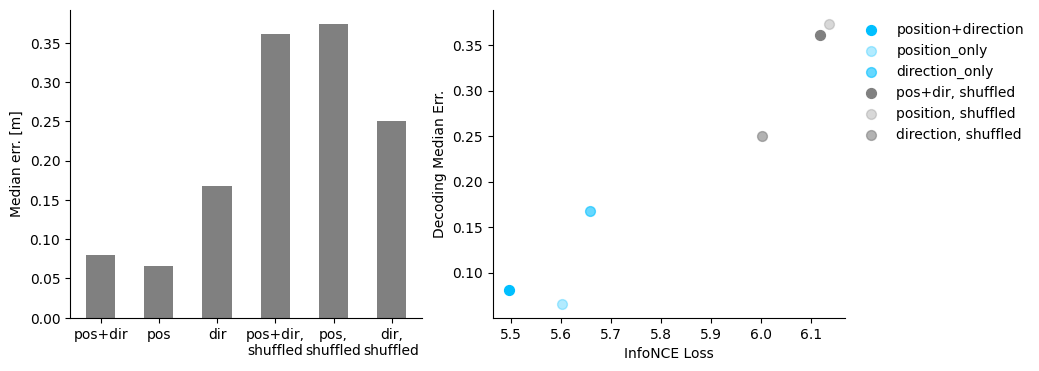

In [26]:
fig = plt.figure(figsize=(10,4))
ax1= plt.subplot(121)
ax1.bar(np.arange(6), 
        [hypothesis_decode['posdir'], hypothesis_decode['pos'], hypothesis_decode['dir'], 
         hypothesis_decode['posdir-shuffled'], hypothesis_decode['pos-shuffled'], hypothesis_decode['dir-shuffled']],
         width = 0.5, color = 'gray')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xticks(np.arange(6))
ax1.set_xticklabels(['pos+dir', 'pos', 'dir', 'pos+dir,\nshuffled', 'pos,\nshuffled', 'dir,\nshuffled'])
ax1.set_ylabel('Median err. [m]')

ax2 = plt.subplot(122)
ax2.scatter(hypothesis_loss['posdir'][-1],hypothesis_decode['posdir'], s=50, c='deepskyblue', label = 'position+direction')
ax2.scatter(hypothesis_loss['pos'][-1],hypothesis_decode['pos'], s=50, c='deepskyblue', alpha = 0.3, label = 'position_only')
ax2.scatter(hypothesis_loss['dir'][-1],hypothesis_decode['dir'], s=50, c='deepskyblue', alpha=0.6,label = 'direction_only')
ax2.scatter(hypothesis_loss['posdir-shuffled'][-1],hypothesis_decode['posdir-shuffled'], s=50, c='gray', label = 'pos+dir, shuffled')
ax2.scatter(hypothesis_loss['pos-shuffled'][-1],hypothesis_decode['pos-shuffled'], s=50, c='gray', alpha = 0.3, label = 'position, shuffled')
ax2.scatter(hypothesis_loss['dir-shuffled'][-1],hypothesis_decode['dir-shuffled'], s=50, c='gray', alpha=0.6,label = 'direction, shuffled')

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlabel('InfoNCE Loss')
ax2.set_ylabel('Decoding Median Err.')
plt.legend(bbox_to_anchor=(1,1), frameon = False )
plt.show()